In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import optuna

In [2]:
train_data = pd.read_csv('train.csv')
print(train_data.shape)
test_data = pd.read_csv('test.csv')
print(test_data.shape)


(700000, 26)
(300000, 25)


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

In [4]:
test_data.isna().sum()

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


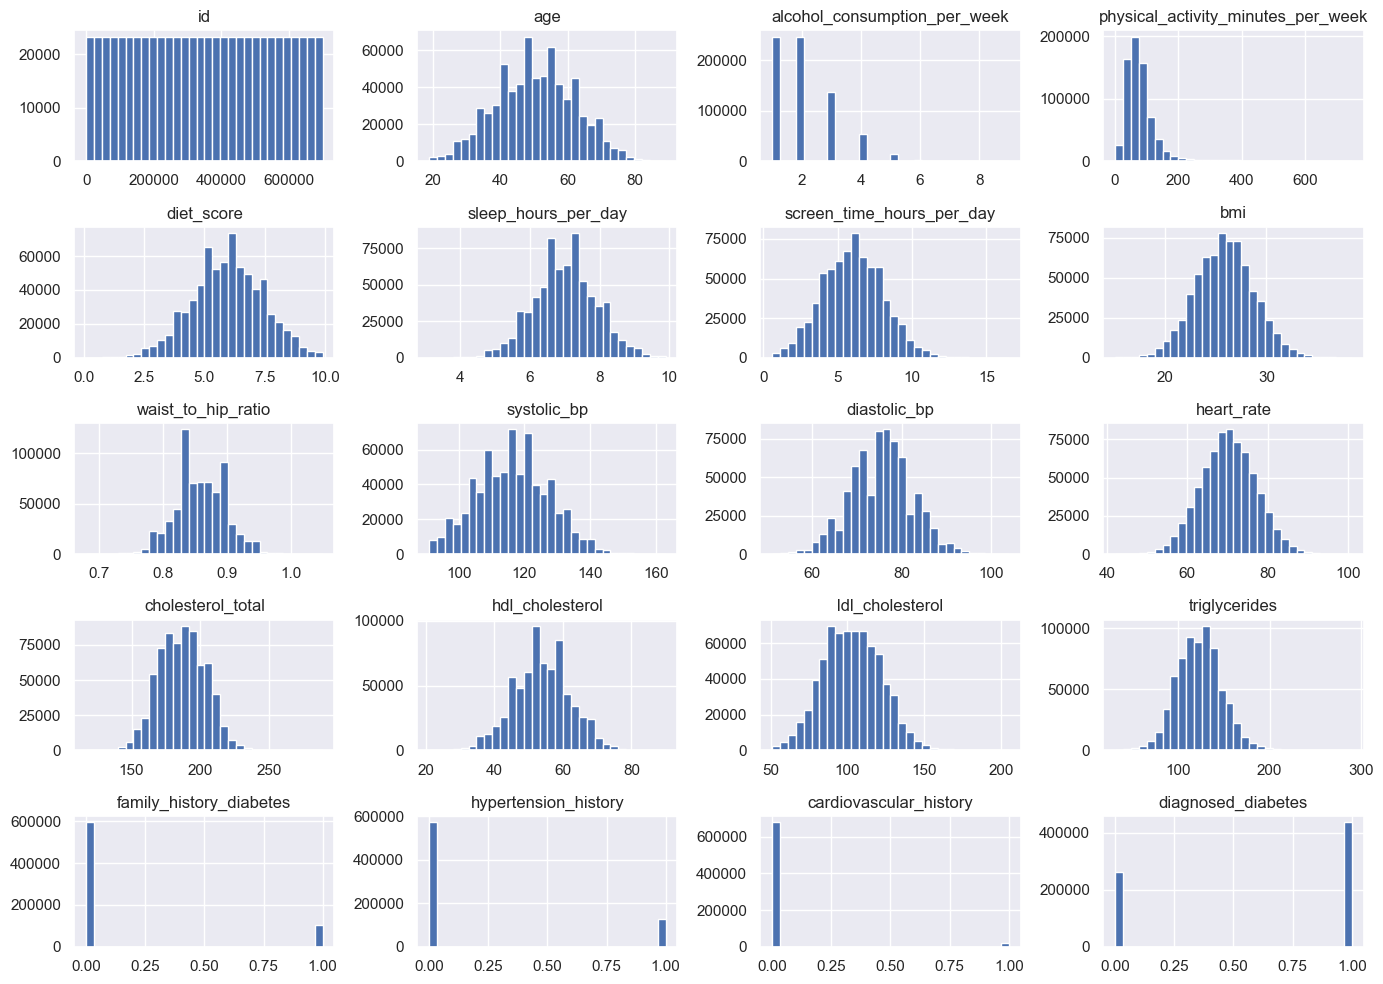

In [5]:
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
train_data.hist(bins=30, figsize=(14, 10))
plt.tight_layout()

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'alcohol_consumption_per_week'}>,
        <Axes: title={'center': 'physical_activity_minutes_per_week'}>],
       [<Axes: title={'center': 'diet_score'}>,
        <Axes: title={'center': 'sleep_hours_per_day'}>,
        <Axes: title={'center': 'screen_time_hours_per_day'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'waist_to_hip_ratio'}>,
        <Axes: title={'center': 'systolic_bp'}>,
        <Axes: title={'center': 'diastolic_bp'}>,
        <Axes: title={'center': 'heart_rate'}>],
       [<Axes: title={'center': 'cholesterol_total'}>,
        <Axes: title={'center': 'hdl_cholesterol'}>,
        <Axes: title={'center': 'ldl_cholesterol'}>,
        <Axes: title={'center': 'triglycerides'}>],
       [<Axes: title={'center': 'family_history_diabetes'}>,
        <Axes: title={'center': 'hypertension_history'}>,
        <Axes: title={'center': 'cardiovas

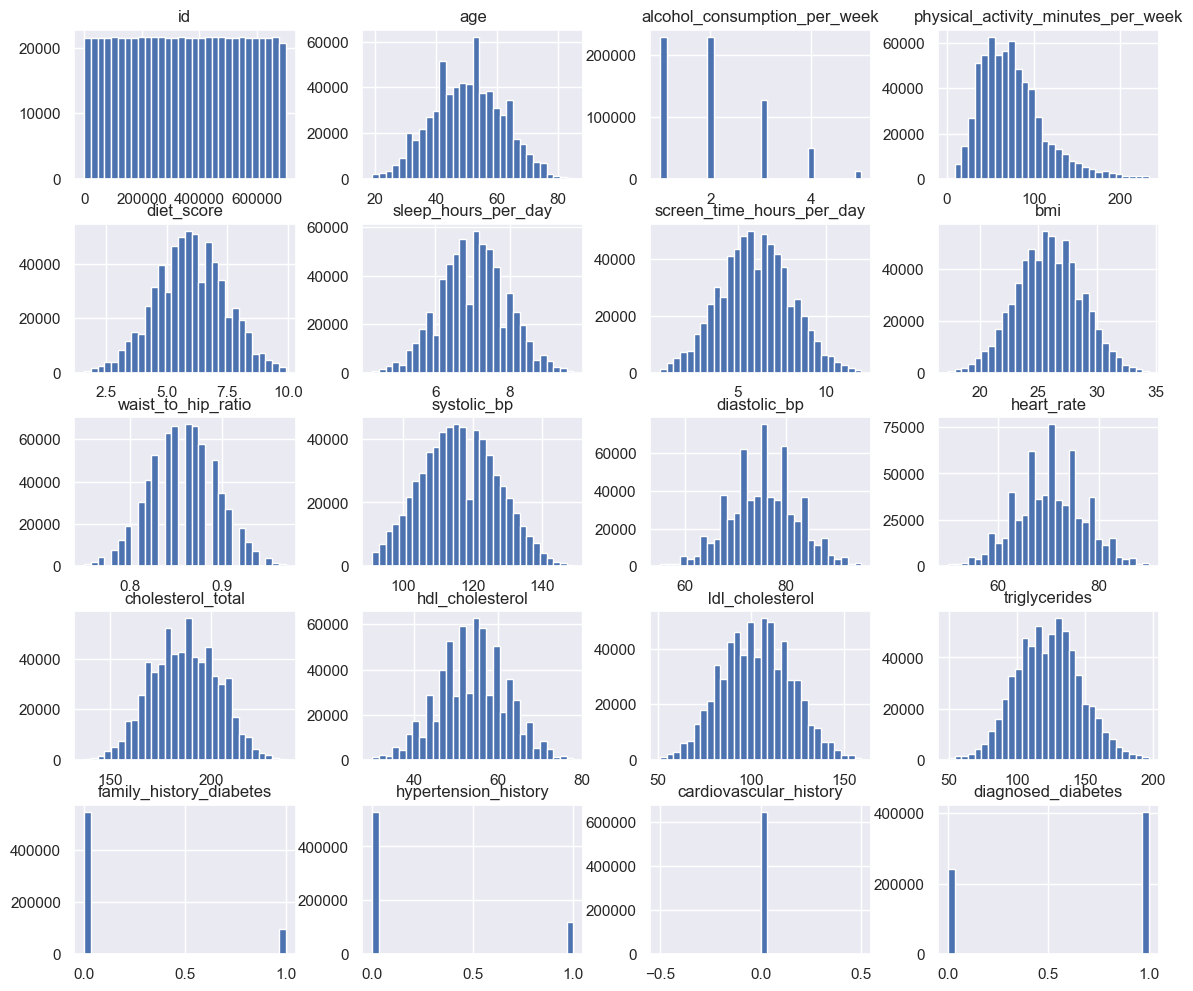

In [6]:
from scipy.stats import zscore

num_cols = train_data.select_dtypes(include=[np.number]).columns.to_list()


outlier_mask = pd.Series([False] * len(train_data), index=train_data.index)

threshold = 3
for column in num_cols:
    non_na = train_data[column].notna()
    z_scores = pd.Series([np.nan] * len(train_data), index=train_data.index)
    z_scores.loc[non_na] = zscore(train_data.loc[non_na, column])
    
    z_outliers = (z_scores > threshold) | (z_scores < -threshold)
    outlier_mask |= z_outliers  # Добавляем в общую маску

# --- ---
df_with_outliers = train_data[outlier_mask].copy()


train_data_data = train_data[~outlier_mask]
train_data_data.hist(bins= 30,figsize = (14,12))


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'alcohol_consumption_per_week'}>,
        <Axes: title={'center': 'physical_activity_minutes_per_week'}>,
        <Axes: title={'center': 'diet_score'}>],
       [<Axes: title={'center': 'sleep_hours_per_day'}>,
        <Axes: title={'center': 'screen_time_hours_per_day'}>,
        <Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'waist_to_hip_ratio'}>,
        <Axes: title={'center': 'systolic_bp'}>],
       [<Axes: title={'center': 'diastolic_bp'}>,
        <Axes: title={'center': 'heart_rate'}>,
        <Axes: title={'center': 'cholesterol_total'}>,
        <Axes: title={'center': 'hdl_cholesterol'}>,
        <Axes: title={'center': 'ldl_cholesterol'}>],
       [<Axes: title={'center': 'triglycerides'}>,
        <Axes: title={'center': 'education_level'}>,
        <Axes: title={'center': 'income_level'}>,
        <Axes: title={'center': 'smoking_status'}>,
       

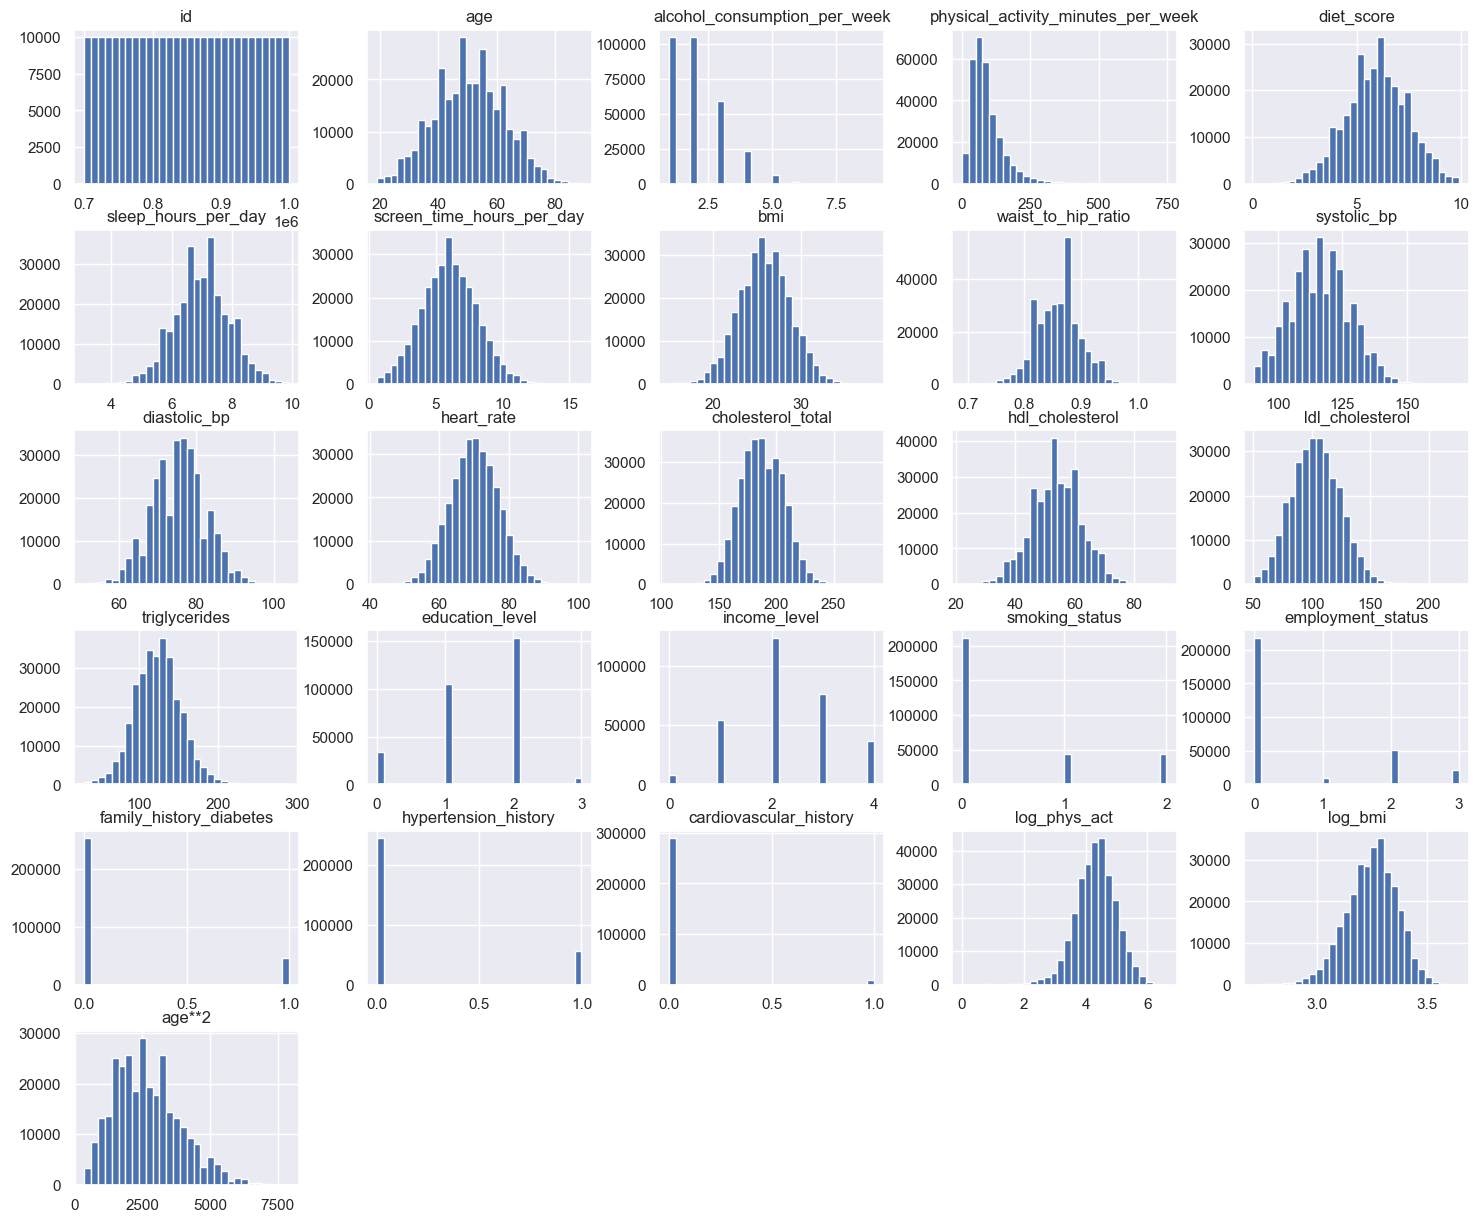

In [79]:
test_data.hist(bins=30,figsize=(18,15))

In [7]:
seed = 52
metric = 'AUC'
n_folds = 3 # большой датасет


In [8]:
from sklearn.model_selection import train_test_split

y = train_data.diagnosed_diabetes
X = train_data.drop(columns=["diagnosed_diabetes"])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=seed)

In [9]:
num_cat_cols = ['family_history_diabetes','hypertension_history','cardiovascular_history']
num_ord_cols = ['alcohol_consumption_per_week']
obj_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
obj_cols

['gender',
 'ethnicity',
 'education_level',
 'income_level',
 'smoking_status',
 'employment_status']

In [10]:
for col in obj_cols:
    print(f"{X_train[col].value_counts(dropna=False)}")
    print("=" * 40)

gender
Female    254327
Male      233126
Other       2547
Name: count, dtype: int64
ethnicity
White       269877
Hispanic     91065
Black        74490
Asian        42317
Other        12251
Name: count, dtype: int64
education_level
Highschool      240923
Graduate        183051
Postgraduate     55508
No formal        10518
Name: count, dtype: int64
income_level
Middle          203364
Lower-Middle    125179
Upper-Middle     89375
Low              60081
High             12001
Name: count, dtype: int64
smoking_status
Never      345891
Current     72522
Former      71587
Name: count, dtype: int64
employment_status
Employed      361399
Retired        80883
Unemployed     34901
Student        12817
Name: count, dtype: int64


In [11]:
obj_cat_cols = ['gender','ethnicity']
obj_ord_cols = ['education_level','income_level','smoking_status','employment_status']

cat_cols = obj_cat_cols + num_cat_cols
ord_cols = obj_ord_cols + num_ord_cols
print(cat_cols)
print(ord_cols)

['gender', 'ethnicity', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
['education_level', 'income_level', 'smoking_status', 'employment_status', 'alcohol_consumption_per_week']


In [12]:
for col in ord_cols:
    print(f"{X_train[col].value_counts(dropna=False)}")
    print("=" * 40)

education_level
Highschool      240923
Graduate        183051
Postgraduate     55508
No formal        10518
Name: count, dtype: int64
income_level
Middle          203364
Lower-Middle    125179
Upper-Middle     89375
Low              60081
High             12001
Name: count, dtype: int64
smoking_status
Never      345891
Current     72522
Former      71587
Name: count, dtype: int64
employment_status
Employed      361399
Retired        80883
Unemployed     34901
Student        12817
Name: count, dtype: int64
alcohol_consumption_per_week
2    172838
1    172369
3     96212
4     37042
5      9300
6      1891
7       315
8        32
9         1
Name: count, dtype: int64


In [13]:
for col in ord_cols:
    print(f"{X_valid[col].value_counts(dropna=False)}")
    print("=" * 40)

education_level
Highschool      103222
Graduate         78217
Postgraduate     24134
No formal         4427
Name: count, dtype: int64
income_level
Middle          87193
Lower-Middle    53391
Upper-Middle    38461
Low             25722
High             5233
Name: count, dtype: int64
smoking_status
Never      148557
Current     30841
Former      30602
Name: count, dtype: int64
employment_status
Employed      154771
Retired        34852
Unemployed     14886
Student         5491
Name: count, dtype: int64
alcohol_consumption_per_week
1    73942
2    73754
3    41353
4    15931
5     4022
6      837
7      132
8       27
9        2
Name: count, dtype: int64


In [14]:
print(f"{test_data.isna().sum()}")

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


In [15]:
for col in ord_cols:
    print(f"{test_data[col].value_counts(dropna=False)}")
    print("=" * 40)

education_level
Highschool      153355
Graduate        105440
Postgraduate     34118
No formal         7087
Name: count, dtype: int64
income_level
Middle          124249
Lower-Middle     76285
Upper-Middle     54624
Low              36816
High              8026
Name: count, dtype: int64
smoking_status
Never      211666
Former      44438
Current     43896
Name: count, dtype: int64
employment_status
Employed      217993
Retired        51207
Unemployed     21881
Student         8919
Name: count, dtype: int64
alcohol_consumption_per_week
1    104820
2    104723
3     59091
4     23407
5      6305
6      1401
7       215
8        37
9         1
Name: count, dtype: int64


In [16]:
print(train_data['diagnosed_diabetes'].value_counts(normalize=True))

diagnosed_diabetes
1.0    0.623296
0.0    0.376704
Name: proportion, dtype: float64


In [71]:
ordinal_mappings = {
    "education_level": ["Postgraduate", "Graduate", "Highschool", "No formal"],
    "income_level": ["High", "Upper-Middle", "Middle", "Lower-Middle", "Low"],
    "smoking_status": ["Never", "Former", "Current"],
    "employment_status": ["Employed", "Student", "Retired", "Unemployed"],
}

# Все датафреймы, которые могут содержать эти столбцы
dataframes_to_encode = {
    "X_train": X_train,
    "X_valid": X_valid,
    "test_data": test_data,
}

for name, df in dataframes_to_encode.items():
    for col, levels in ordinal_mappings.items():
        if col in df.columns:
            # Проверка на неожиданные значения
            unique_vals = set(df[col].dropna().unique())
            expected_set = set(levels)
            unexpected = unique_vals - expected_set
            if unexpected:
                print(f"⚠️ {name}[{col}]: неизвестные значения — {unexpected}")
            
            # Безопасное отображение: неизвестные → остаются как NaN
            mapping_dict = {level: i for i, level in enumerate(levels)}
            df[col] = df[col].map(mapping_dict)

            # Опционально: если допустимы только известные значения — прервите
            if df[col].isna().any() and df[col].notna().any():
                print(f"❗ {name}[{col}]: появились NaN после кодирования")

In [18]:
def constant_feature_detect(data,threshold=0.98):
    """ detect features that show the same value for the 
    majority/all of the observations (constant/quasi-constant features)
    
    Parameters
    ----------
    data : pd.Dataframe
    threshold : threshold to identify the variable as constant
        
    Returns
    -------
    list of variables names
    """
    
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() /float(
                      len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),' variables are found to be almost constant')    
    return quasi_constant_feature

In [19]:
quasi_constant_feature = constant_feature_detect(data=X_train,threshold=0.95)
quasi_constant_feature      

1  variables are found to be almost constant


['cardiovascular_history']

In [20]:
X_train.sample(2)

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
659752,659752,38,3,108,4.9,6.0,6.9,19.4,0.80,101,...,111,Female,White,0,4,1,0,1,0,0
507421,507421,40,1,35,6.6,7.7,5.4,26.4,0.86,126,...,106,Female,Hispanic,3,3,0,0,0,0,0


In [21]:
X_valid.sample(2)

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
453861,453861,48,1,120,4.6,5.6,8.3,26.5,0.83,116,...,139,Female,Other,1,4,0,3,0,0,0
545502,545502,36,2,32,4.5,5.8,5.8,26.6,0.87,131,...,150,Female,White,1,1,0,2,0,0,0


In [22]:
test_data.sample(2)

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,triglycerides,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history
175345,875345,57,1,39,6.7,5.5,7.9,24.2,0.86,119,...,132,Male,Hispanic,1,2,0,2,0,0,0
113638,813638,61,1,120,5.7,6.7,5.7,27.5,0.84,139,...,109,Female,Hispanic,1,3,0,2,0,0,0


In [23]:
from catboost import CatBoostClassifier, Pool

def modeltraining(X_train,y_train,X_test,y_test,params):
    ''' Function for training model and show results.
        X - full training dataset (pd.DataFrame)
        y - target  (pd.Series)
        cat_features - list of categorical features from dataset
        params - dict of parameters passed to the model
        metric - str with catboost name of metric
        seed - random_state
        '''
        
   
    train_dataset = Pool(data=X_train, label=y_train, cat_features= params['cat_features'])
    eval_dataset = Pool(data=X_test, label=y_test, cat_features= params['cat_features'])

    cbc = CatBoostClassifier(**params)
    cbc.fit(
            train_dataset,
            eval_set=eval_dataset,
            verbose=500,
            use_best_model=True,
            plot=True)

    print(f'Score on validation dataset: {cbc.best_score_["validation"]}')
    
    importances = pd.Series(cbc.feature_importances_, index=X_train.columns)
    
    importances_sorted = importances.sort_values(ascending=False)
    feature_names = importances_sorted.index
    sorted_vals = importances_sorted.values
    
    y_pos = np.arange(len(feature_names))
    
    plt.figure(figsize=(10, 8))
    plt.barh(y_pos, sorted_vals, align='center', alpha=0.8)
    
    for i, val in enumerate(sorted_vals):
        plt.text(
            val + max(sorted_vals) * 0.01,  # немного отступ от бара
            i,
            f'{val:.4f}',
            va='center',
            ha='left',
            fontsize=9
        )
    
    plt.yticks(y_pos, feature_names)
    plt.xlabel('Feature Importance (Gain)')
    plt.title('CatBoost Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    y_pred = cbc.predict(eval_dataset)
    errors_mask = (y_pred != y_test.values)
    X_errors = X_test.copy()
    X_true_pred = X_test.copy()
    X_errors['true_target'] = y_test.values
    X_true_pred['true_target'] = y_test.values
    X_errors = X_errors[errors_mask].copy()
    X_true_pred = X_true_pred[y_pred == y_test].copy()
    return cbc, X_errors, X_true_pred

In [24]:
params = {
    'eval_metric' : metric,
    'cat_features': cat_cols,
    'use_best_model': True,
    'early_stopping_rounds': 100,
    'random_seed': seed,
    'ignored_features': None,
    'verbose': False
    }

# Первый запуск (0.7245)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146348
0:	test: 0.6732576	best: 0.6732576 (0)	total: 348ms	remaining: 5m 47s
500:	test: 0.7238950	best: 0.7239096 (487)	total: 1m 38s	remaining: 1m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7244932398
bestIteration = 662

Shrink model to first 663 iterations.
Score on validation dataset: {'Logloss': 0.5845142797866971, 'AUC': 0.7244932397764604}


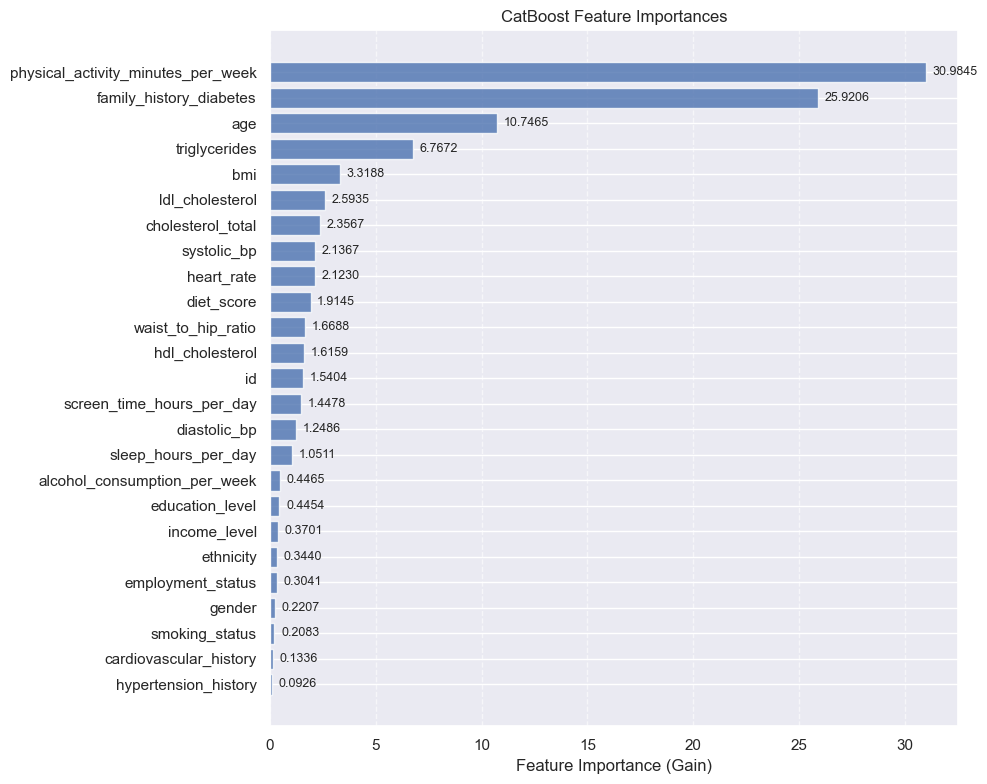

In [25]:
_ = modeltraining(X_train,y_train,X_valid,y_valid,params)

# Изменения 1 (0.7247) (deleted)

# Изменения 2 (0.72458)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146348
0:	test: 0.6740834	best: 0.6740834 (0)	total: 220ms	remaining: 3m 39s
500:	test: 0.7241566	best: 0.7241638 (498)	total: 1m 42s	remaining: 1m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.724580779
bestIteration = 658

Shrink model to first 659 iterations.
Score on validation dataset: {'Logloss': 0.584414650737068, 'AUC': 0.7245807790157124}


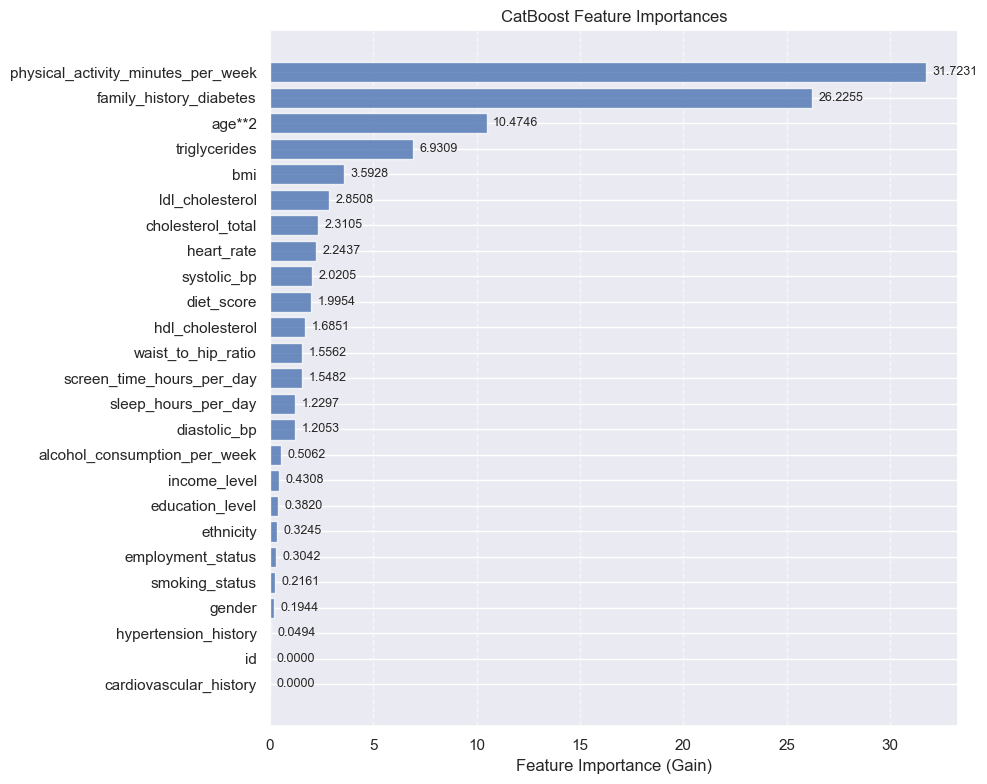

In [26]:
X_train2 = X_train.copy()
X_valid2 = X_valid.copy()

X_train2['age**2'] = X_train2.age ** 2
X_valid2['age**2'] = X_valid2.age ** 2

X_train2.drop(['age'],axis = 1,inplace= True)
X_valid2.drop(['age'],axis = 1,inplace= True)

params2 = params.copy()
params2['ignored_features'] = ['id','cardiovascular_history']

model, X_errors, X_true = modeltraining(X_train2,y_train,X_valid2,y_valid,params2)

Все числовые колонки отображены.


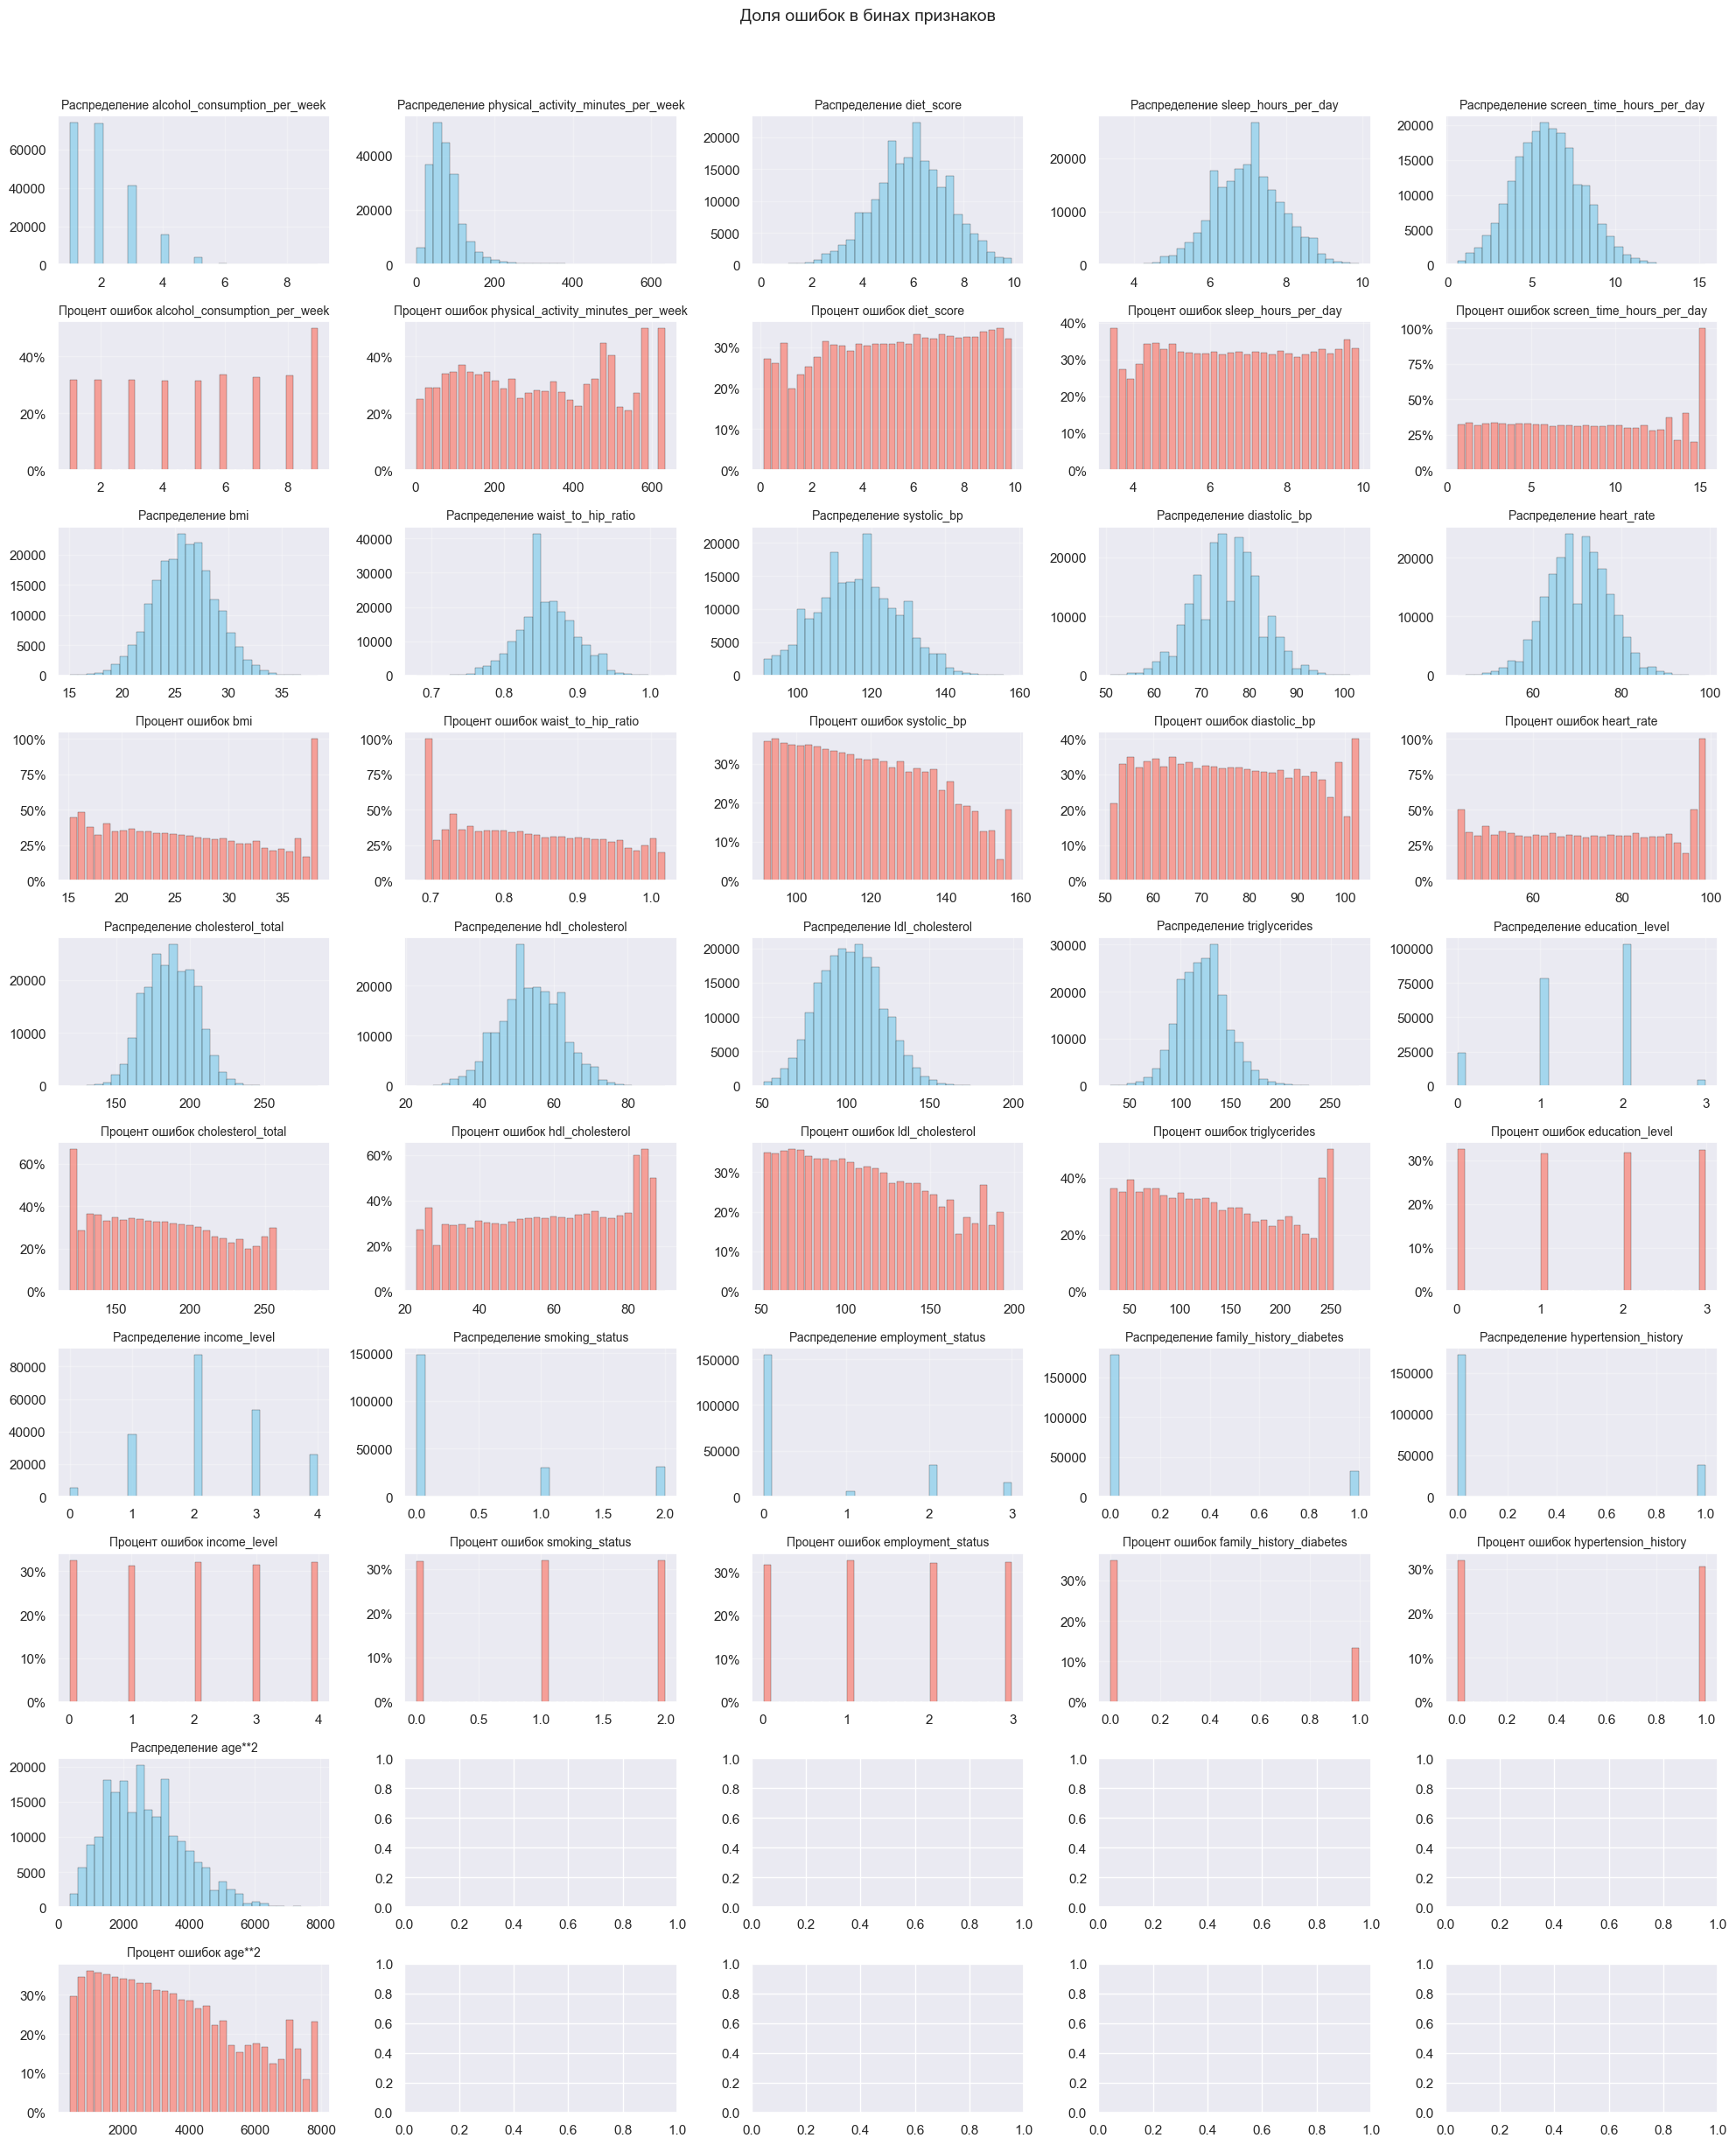

Всего категориальных колонок: 2
Показано: 2


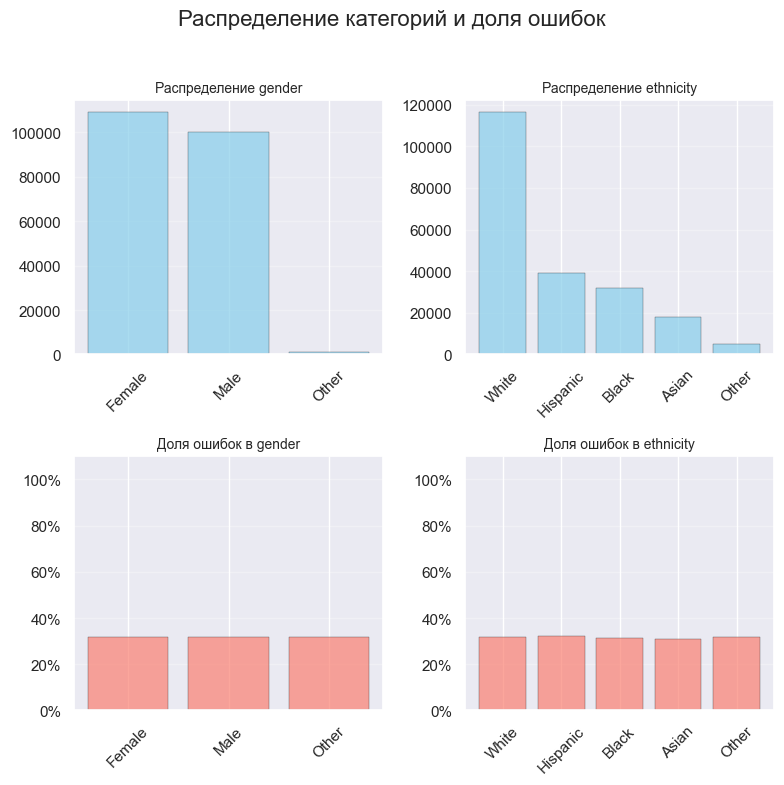

In [27]:
def plot_error_rate_per_bin(df_errors, df_correct, drop_cols=None):
    """
    Визуализация доли ошибок в каждом бине признака.
    Расчёт: (число ошибок в бине) / (число всех объектов в бине)
    """
    errors = df_errors.copy()
    correct = df_correct.copy()

    # Удаляем служебные колонки
    default_drop = {'id', 'true_label', 'pred_label', 'error_type', 'confidence', 'index'}
    if drop_cols:
        default_drop.update(drop_cols)
    
    for col in default_drop:
        errors = errors.drop(columns=[col], errors='ignore')
        correct = correct.drop(columns=[col], errors='ignore')
    
    # Числовые признаки
    num_cols = errors.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 25:
        stds = errors[num_cols].std().sort_values(ascending=False)
        cols_to_plot = stds.head(25).index.tolist()
    else:
        cols_to_plot = num_cols

    
    n = len(cols_to_plot)
    if n == 0:
        return

    ncols_fig = 5
    nrows_fig = 2 * (n + ncols_fig - 1) // ncols_fig

    fig, axes = plt.subplots(
        nrows=nrows_fig,
        ncols=ncols_fig,
        figsize=(4 * ncols_fig, 2.5 * nrows_fig)
    )

    if nrows_fig == 1 and ncols_fig == 1:
        axes = np.array([[axes]])
    elif nrows_fig == 1:
        axes = np.array([axes])
    elif ncols_fig == 1:
        axes = np.array([[ax] for ax in axes])
    else:
        axes = np.array(axes)

    fig.suptitle('Доля ошибок в бинах признаков', fontsize=14)

    # Объединяем данные для определения общих бинов
    combined = pd.concat([errors, correct], ignore_index=True)

    for idx, col in enumerate(cols_to_plot):
        row_cell = idx // ncols_fig
        col_cell = idx % ncols_fig
        # ax = axes[row, col_idx] if nrows_fig > 1 or ncols_fig > 1 else axes[0, 0]

        ax_top = axes[2 * row_cell][col_cell]
                # Нижний subplot — верные
        ax_bottom = axes[2 * row_cell + 1][col_cell]
        

        # Определяем бины по объединённым данным
        bins = np.histogram_bin_edges(combined[col].dropna(), bins=30)
        
        # Гистограммы для всех, ошибок и верных
        hist_all, _ = np.histogram(combined[col].dropna(), bins=bins)
        hist_err, _ = np.histogram(errors[col].dropna(), bins=bins) if len(errors) > 0 else (np.zeros(len(bins)-1), None)
        hist_corr, _ = np.histogram(correct[col].dropna(), bins=bins) if len(correct) > 0 else (np.zeros(len(bins)-1), None)

        # Безопасное деление: избегаем деления на ноль
        error_rate = np.divide(hist_err, hist_all, out=np.zeros_like(hist_err, dtype=float), where= hist_all!=0)

        # Центры бинов для отрисовки
        bin_centers = (bins[:-1] + bins[1:]) / 2

        if col in combined.columns:
            vals_err = combined[col].dropna()
            ax_top.hist(vals_err, bins=30, color='skyblue', alpha=0.7, edgecolor='k', linewidth=0.3)
            ax_top.set_title(f'Распределение {col}', fontsize=10)
            ax_top.grid(True, alpha=0.3)
        

        # Столбчатая диаграмма доли ошибок
        if col in correct.columns:
            ax_bottom.bar(
                bin_centers,
                error_rate,
                width=(bins[1] - bins[0]) * 0.8,
                color='salmon',
                alpha=0.7,
                edgecolor='k',
                linewidth=0.3
            )
            ax_bottom.set_title(f'Процент ошибок {col}', fontsize=10)
            ax_bottom.grid(True, alpha=0.3)
        

    # Формат оси Y в процентах
    for i in range(1, axes.shape[0], 2):
        for j in range(axes.shape[1]):
            if axes[i, j].has_data():
                axes[i, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    all_numeric = errors.select_dtypes(include=[np.number]).columns.tolist()
    shown = cols_to_plot
    skipped = [col for col in all_numeric if col not in shown]
        
    if skipped:
        print(f"Всего числовых колонок: {len(all_numeric)}")
        print(f"Пропущено ({len(skipped)}): {skipped}")
    else:
        print("Все числовые колонки отображены.")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # ===================================Категориальные=================================
    cat_cols = errors.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    # Лимит на количество колонок
    if len(cat_cols) > 25:
        # Сортируем по количеству уникальных значений (чем меньше, тем информативнее визуально)
        nunique = errors[cat_cols].nunique().sort_values()
        cols_to_plot = nunique.head(25).index.tolist()
    else:
        cols_to_plot = cat_cols

    n = len(cols_to_plot)
    if n == 0:
        print("Категориальные колонки не найдены.")
        return

    ncols_fig = 5 if n > 5 else 2
    nrows_fig = 2 * ((n + ncols_fig - 1) // ncols_fig)

    fig, axes = plt.subplots(
        nrows=nrows_fig,
        ncols=ncols_fig,
        figsize=(4 * ncols_fig, 4 * nrows_fig) # Увеличил высоту для подписей категорий
    )

    # Приведение axes к 2D массиву для удобства индексации
    if nrows_fig == 1: axes = axes[np.newaxis, :]
    if ncols_fig == 1: axes = axes[:, np.newaxis]

    fig.suptitle('Распределение категорий и доля ошибок', fontsize=16, y=0.98)


    combined = pd.concat([errors, correct], ignore_index=True)

    for idx, col in enumerate(cols_to_plot):
        row_cell = idx // ncols_fig
        col_cell = idx % ncols_fig
        
        ax_top = axes[2 * row_cell][col_cell]
        ax_bottom = axes[2 * row_cell + 1][col_cell]

        # Считаем общее распределение (топ 10 категорий для читаемости)
        total_counts = combined[col].value_counts(dropna=True).head(10)
        categories = total_counts.index.tolist()
        
        # Данные для графиков
        err_counts = errors[col].value_counts().reindex(categories, fill_value=0)
        all_counts = combined[col].value_counts().reindex(categories, fill_value=0)
        
        # Доля ошибок
        error_rate = (err_counts / all_counts).fillna(0)

        # 1. Верхний график: Распределение объектов (Count Plot)
        ax_top.bar(categories, all_counts, color='skyblue', alpha=0.7, edgecolor='k', linewidth=0.3)
        ax_top.set_title(f'Распределение {col}', fontsize=10)
        ax_top.tick_params(axis='x', rotation=45)
        ax_top.grid(True, axis='y', alpha=0.3)

        # 2. Нижний график: Процент ошибок (Error Rate)
        ax_bottom.bar(categories, error_rate, color='salmon', alpha=0.7, edgecolor='k', linewidth=0.3)
        ax_bottom.set_title(f'Доля ошибок в {col}', fontsize=10)
        ax_bottom.tick_params(axis='x', rotation=45)
        ax_bottom.grid(True, axis='y', alpha=0.3)
        ax_bottom.set_ylim(0, 1.1)

    # Форматирование оси Y для нижних графиков (проценты)
    for i in range(1, nrows_fig, 2):
        for j in range(ncols_fig):
            axes[i, j].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

    # Очистка пустых сабплотов, если n не кратно ncols_fig
    for i in range(n, (nrows_fig // 2) * ncols_fig):
        r = i // ncols_fig
        c = i % ncols_fig
        fig.delaxes(axes[2*r][c])
        fig.delaxes(axes[2*r+1][c])

    print(f"Всего категориальных колонок: {len(cat_cols)}")
    print(f"Показано: {len(cols_to_plot)}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_error_rate_per_bin(
   df_errors=X_errors,
   df_correct=X_true,
   drop_cols= params2['ignored_features'] + ['true_target']  
)

# Изменения 3(0.7008)(deleted)

# Изменения 4(0.72108)

In [28]:
X_train44 = X_train.copy()
X_valid4 = X_valid.copy()

y_train44 = y_train.copy()
y_valid4 = y_valid.copy()

data4 = pd.concat([X_train44, y_train44], axis=1)
print(X_train44.shape,data4.shape)    

(490000, 25) (490000, 26)


In [29]:
print(data4.shape)
data4 = data4[data4['gender'] != 'Other']
data4 = data4[data4['physical_activity_minutes_per_week'] <250]
data4 = data4[data4['alcohol_consumption_per_week'] < 5]
data4 = data4[data4['sleep_hours_per_day'] > 4]
data4 = data4[data4['screen_time_hours_per_day'] < 12]
data4 = data4[(data4['bmi'] < 36) | (data4['bmi'] > 17)]
data4 = data4[(data4['heart_rate'] < 95) | (data4['heart_rate'] > 55)]
data4 = data4[(data4['waist_to_hip_ratio'] > 0.75) | (data4['waist_to_hip_ratio'] < 1)]
data4 = data4[data4['cholesterol_total'] > 145]
data4 = data4[data4['triglycerides'] < 220]
print(data4.shape)

(490000, 26)
(464312, 26)


In [30]:
y_train4 = data4.diagnosed_diabetes
X_train4 = data4.drop('diagnosed_diabetes',axis = 1)

In [31]:
params4 = params2.copy()
params4['ignored_features'] = [
    'alcohol_consumption_per_week',
    'income_level',
    'ethnicity',
    'education_level',
    'employment_status',
    'smoking_status',
    'gender',
    'hypertension_history',
    'id',
    'cardiovascular_history'
]

In [32]:
X_train4['very_high_screen_time'] = (X_train4['screen_time_hours_per_day'] > 11).astype(int)
X_train4['very_high_phys_act'] = (X_train4['physical_activity_minutes_per_week'] > 200).astype(int)


X_valid4['very_high_screen_time'] = (X_valid4['screen_time_hours_per_day'] > 11).astype(int)
X_valid4['very_high_phys_act'] = (X_valid4['physical_activity_minutes_per_week'] > 200).astype(int)
cat_cols4 = cat_cols.copy() + ['very_high_screen_time','very_high_phys_act']
params4['cat_features'] = cat_cols4

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.144415
0:	test: 0.6719764	best: 0.6719764 (0)	total: 51.2ms	remaining: 51.1s
500:	test: 0.7201514	best: 0.7210864 (466)	total: 24.2s	remaining: 24.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7210864241
bestIteration = 466

Shrink model to first 467 iterations.
Score on validation dataset: {'Logloss': 0.5871593409971828, 'AUC': 0.7210864241300342}


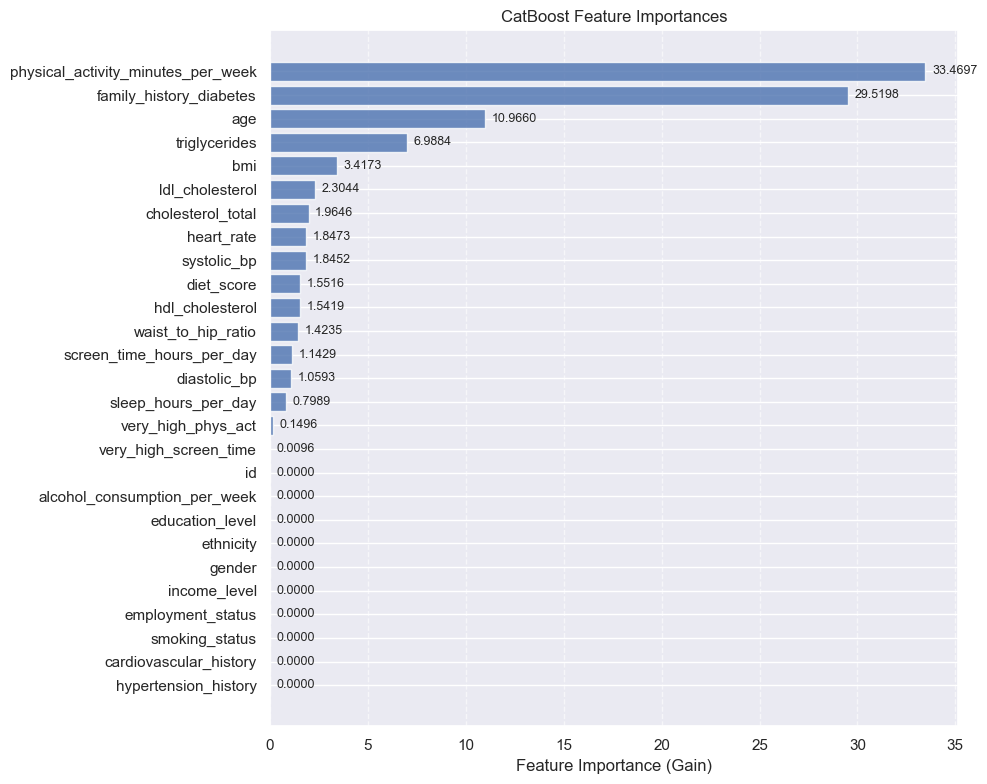

In [33]:
model4, X_errors4, X_true4 = modeltraining(X_train4,y_train4,X_valid4,y_valid4,params4)

Все числовые колонки отображены.


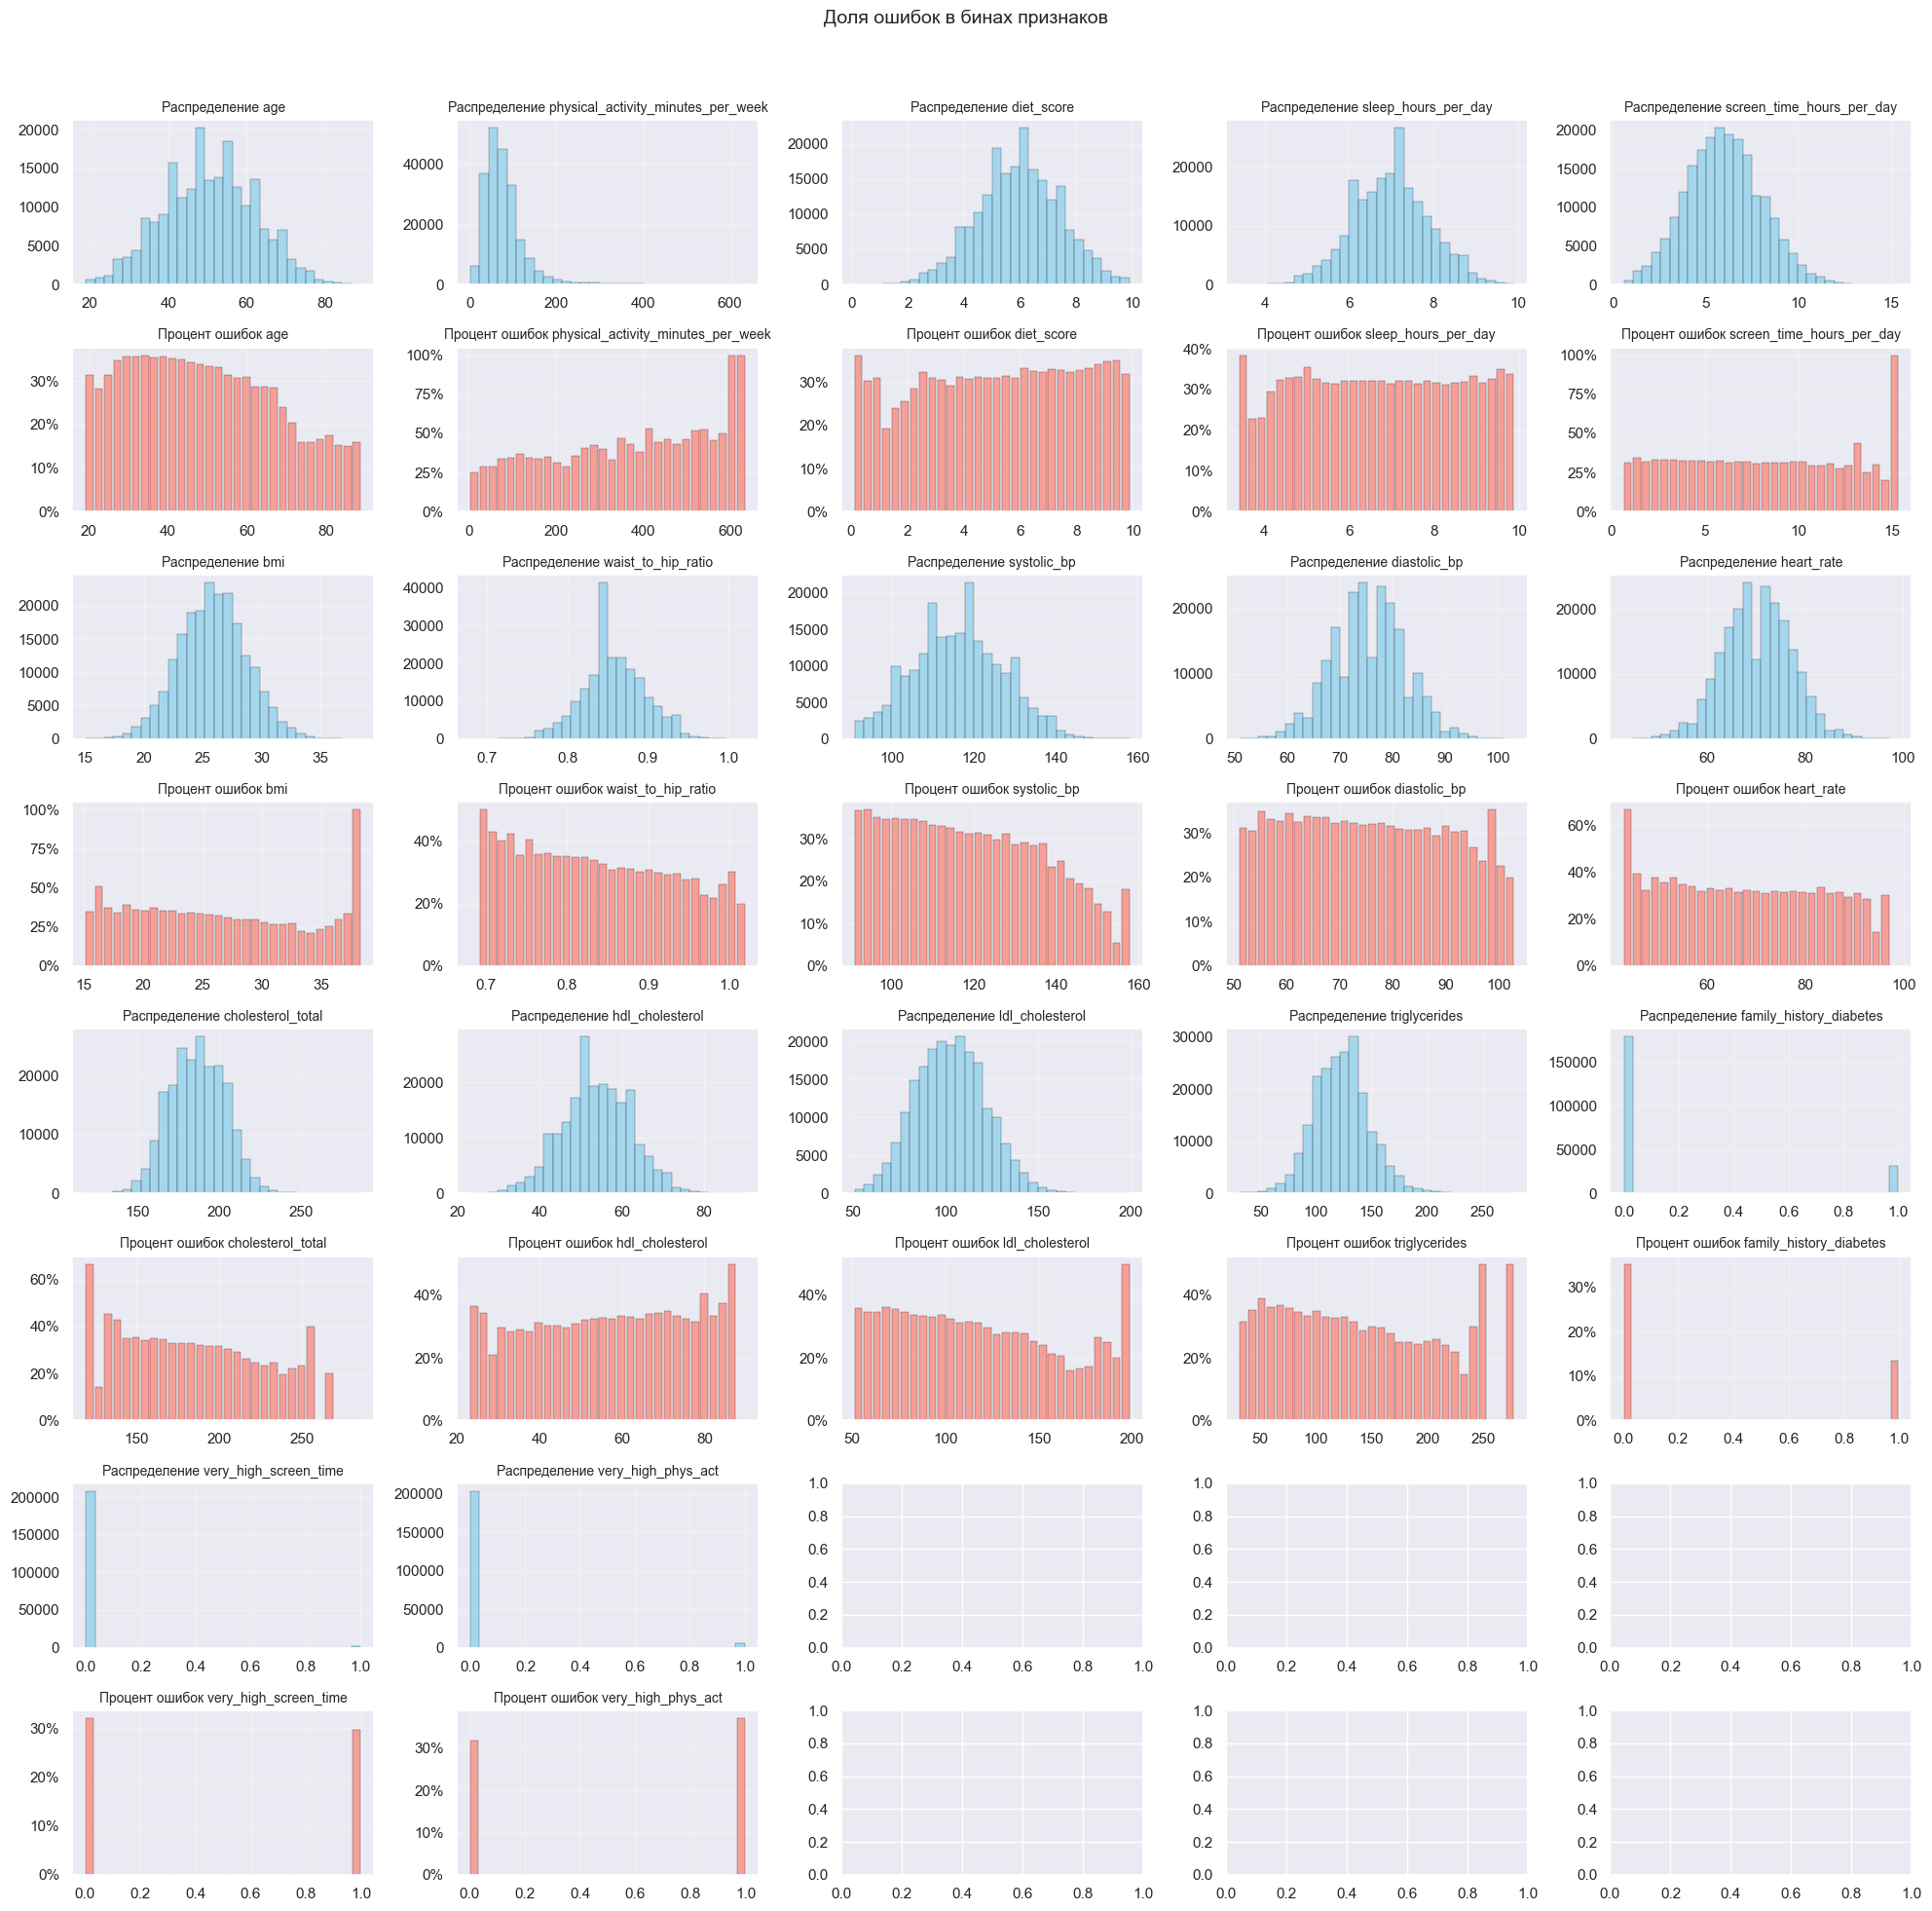

Категориальные колонки не найдены.


In [34]:
plot_error_rate_per_bin(
    df_errors=X_errors4,
    df_correct=X_true4,
    drop_cols= params4['ignored_features'] + ['true_target']
)


# Изменения 5 (0.72486)

In [35]:
X_train5 = X_train.copy()
X_valid5 = X_valid.copy()

y_train5 = y_train.copy()
y_valid5 = y_valid.copy()

In [36]:
X_train5['log_phys_act'] = np.log(X_train5['physical_activity_minutes_per_week'] + 1e-6)
X_valid5['log_phys_act'] = np.log(X_valid5['physical_activity_minutes_per_week'] + 1e-6)
X_train5['log_bmi'] = np.log(X_train5['bmi'] + 1e-6)
X_valid5['log_bmi'] = np.log(X_valid5['bmi'] + 1e-6)

X_train5['age**2'] = X_train5['age'] ** 2
X_valid5['age**2'] = X_valid5['age'] ** 2


params5 = params2.copy()
params5['ignored_features'] = [
    'alcohol_consumption_per_week',
    'education_level',
    'ethnicity',
    'income_level',
    'employment_status',
    'smoking_status',
    'gender',
    'hypertension_history',
    'waist_to_hip_ratio',
    'diet_score',
    'age',
    'id',
    'physical_activity_minutes_per_week',
    'cardiovascular_history'
]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.146348
0:	test: 0.6751715	best: 0.6751715 (0)	total: 57.8ms	remaining: 57.8s
500:	test: 0.7238023	best: 0.7238073 (498)	total: 24.5s	remaining: 24.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7242691426
bestIteration = 717

Shrink model to first 718 iterations.
Score on validation dataset: {'Logloss': 0.5847468612763194, 'AUC': 0.7242691426338357}


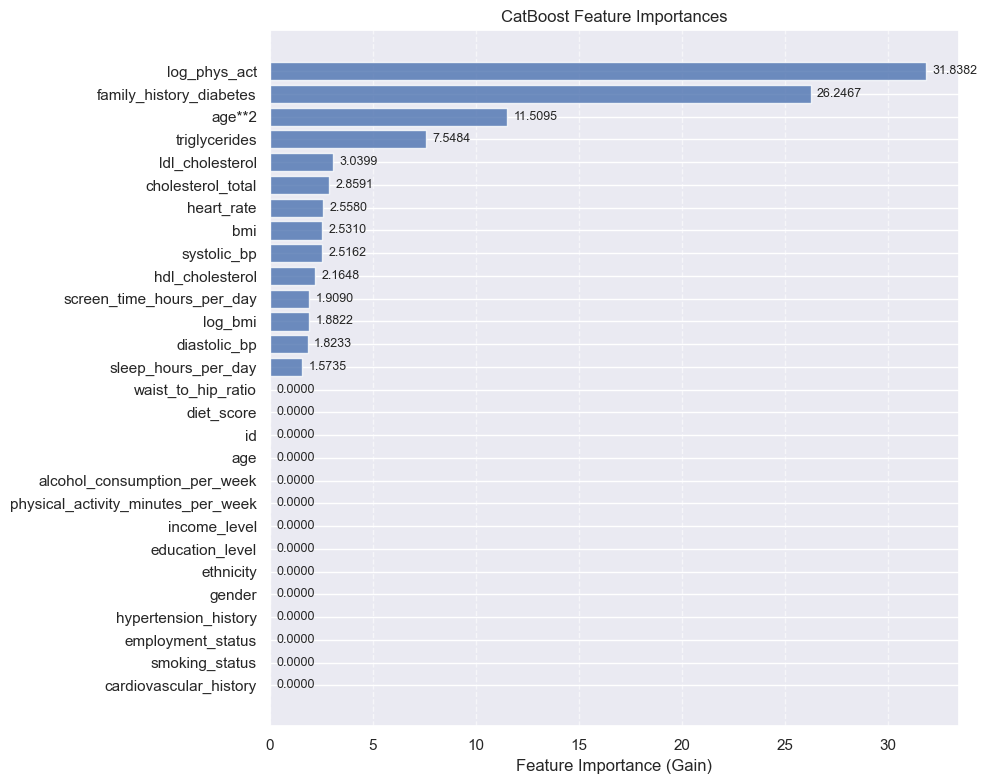

In [37]:
model5, X_errors5, X_true5 = modeltraining(X_train5,y_train5,X_valid5,y_valid5,params5)

Все числовые колонки отображены.


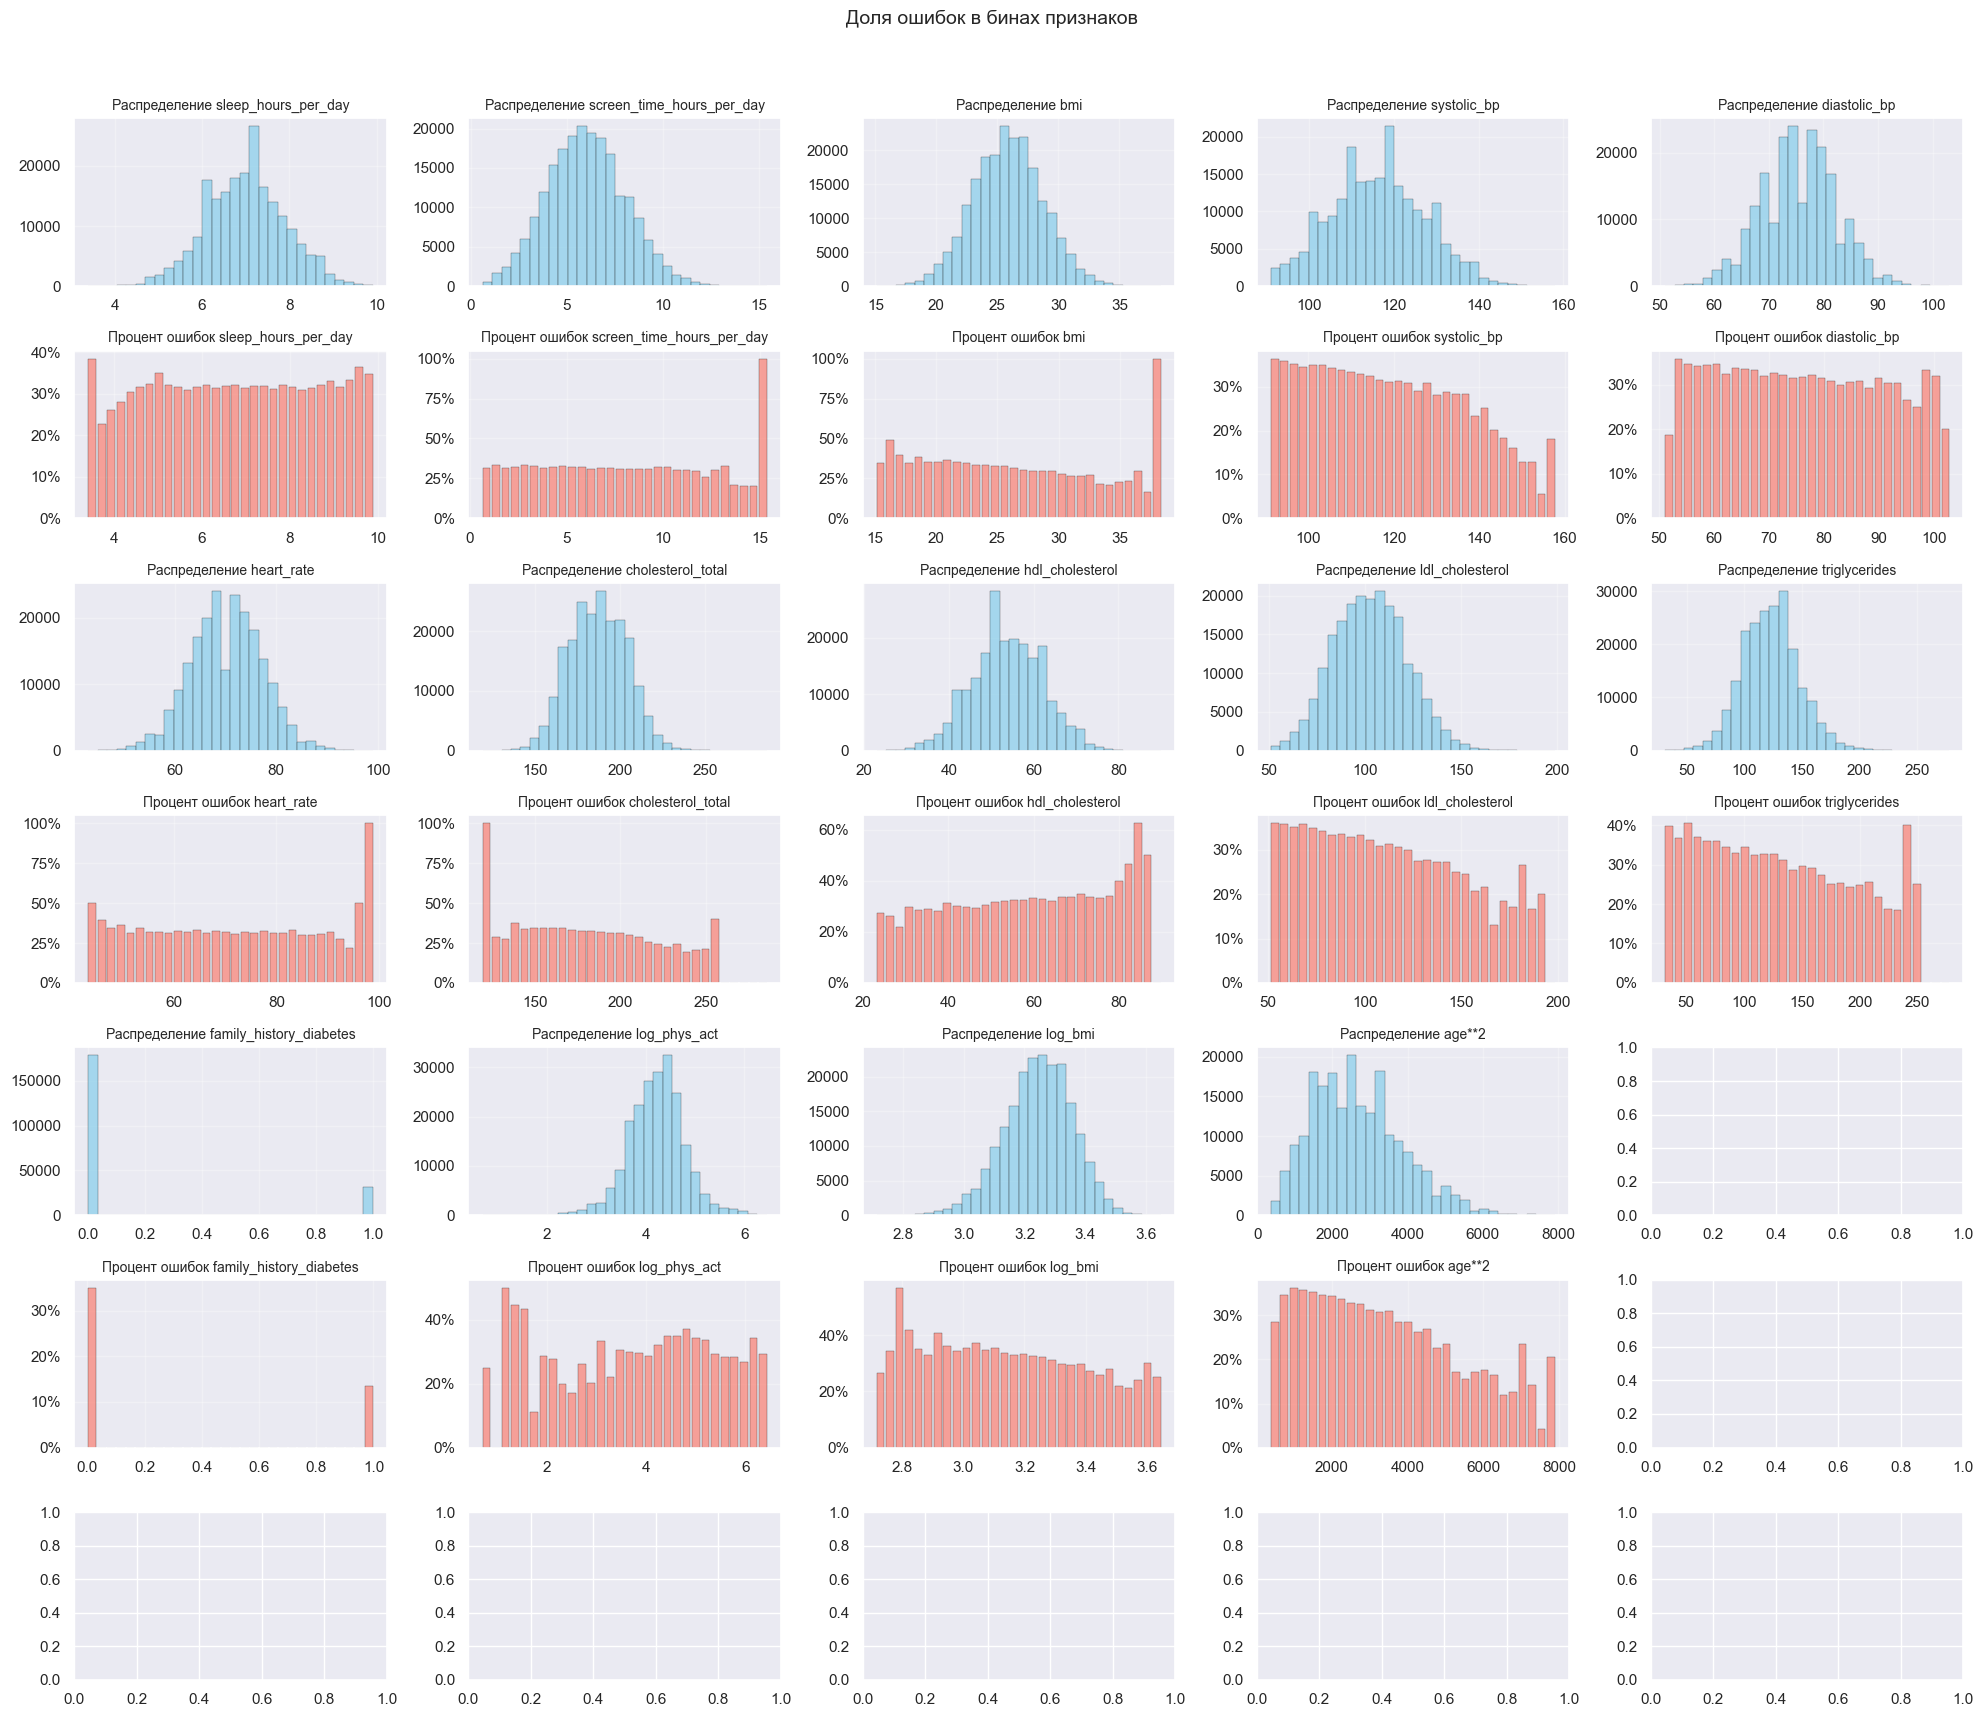

Категориальные колонки не найдены.


In [38]:
plot_error_rate_per_bin(
    df_errors=X_errors5,
    df_correct=X_true5,
    drop_cols= params5['ignored_features'] + ['true_target']  
)


In [45]:
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree','Depthwise', 'Lossguide']), small dataset, symmetricTree + 
        # Ordered boosting type sounds good 
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity',1,4),
        'cat_features': cat_cols,
        'train_dir': None,
        'ignored_features': params5['ignored_features'],
    }

    
    model = CatBoostClassifier(**params, random_seed=seed)
    model.fit(X_train5,y_train5, verbose=0, eval_set=(X_valid5,y_valid5))
    y_pred_raw = model.predict(X_valid5, prediction_type='RawFormulaVal')
    auc = eval_metric(np.asarray(y_valid5), np.asarray(y_pred_raw), metric='AUC')
    return auc

sampler = TPESampler(seed=seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2026-01-10 19:29:27,062] A new study created in memory with name: no-name-50d5c4b8-3001-4319-8495-711e5c3cc8dd
[I 2026-01-10 19:32:16,289] Trial 0 finished with value: 0.7034497840925457 and parameters: {'learning_rate': 0.08407993066388128, 'depth': 4, 'l2_leaf_reg': 2.8969357593816456, 'boosting_type': 'Ordered', 'one_hot_max_size': 7, 'max_ctr_complexity': 1}. Best is trial 0 with value: 0.7034497840925457.
[I 2026-01-10 19:33:49,074] Trial 1 finished with value: 0.7221079980281973 and parameters: {'learning_rate': 0.09645886520238148, 'depth': 10, 'l2_leaf_reg': 5.690148852441014, 'boosting_type': 'Plain', 'one_hot_max_size': 8, 'max_ctr_complexity': 2}. Best is trial 1 with value: 0.7221079980281973.
[I 2026-01-10 19:37:39,719] Trial 2 finished with value: 0.7023123947259068 and parameters: {'learning_rate': 0.07919247756913685, 'depth': 6, 'l2_leaf_reg': 9.334932143741483, 'boosting_type': 'Ordered', 'one_hot_max_size': 9, 'max_ctr_complexity': 2}. Best is trial 1 with value: 

In [ ]:
best_params = study.best_params
print("Best params:", best_params)

Best params: {'learning_rate': 0.09492021308266439, 'depth': 6, 'l2_leaf_reg': 9.086789020950523, 'boosting_type': 'Plain', 'one_hot_max_size': 10, 'max_ctr_complexity': 1}


In [65]:
ended_params ={**params5, **best_params}
ended_params['cat_features'] = ended_params['cat_features'] + ["education_level","income_level","smoking_status","employment_status"]

In [72]:
lastmodel = CatBoostClassifier(**ended_params)
lastmodel.fit(X_train5,y_train5, verbose=0, eval_set=(X_valid5,y_valid5),plot=True)

test_data['log_phys_act'] = np.log(test_data['physical_activity_minutes_per_week'] + 1e-6)

test_data['log_bmi'] = np.log(test_data['bmi'] + 1e-6)

test_data['age**2'] = test_data['age'] ** 2


y_pred_test = lastmodel.predict(test_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [73]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'diagnosed_diabetes': y_pred_test 
})
submission

,id,diagnosed_diabetes
0,700000,0.0
1,700001,1.0
2,700002,1.0
3,700003,0.0
4,700004,1.0
...,...,...
299995,999995,1.0
299996,999996,1.0
299997,999997,1.0
299998,999998,1.0


In [75]:
submission.to_csv('submission.csv', index=False)

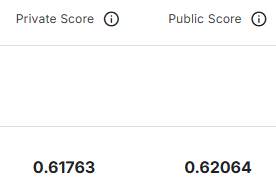

На соревновании пишут что там был сдвиг в данных, и то что распределения плывут на тесте относительно трейна, моя ошибка заключалась в этом.